# Benchmark: PXD014777 HeLa 10 replicate dataset

This notebook contains code to benchmark the PIPP model on [PXD014777 HeLa 10 replicate dataset](https://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD014777). Here, we'll use two txt files from the dataset:

- allPeptides.txt: All the peptides with MS-1 data
- evidence.txt: A subset of the peptides in allPeptides.txt, which contains both MS-1 and MS-2 data

We'll use PIPP to compute the embeddings of each MS-1 datapoint. Followed by peptide identity propagation using the MS1/MS2 data as the support data.

Let's start with the imports.

In [1]:
%%capture

%matplotlib inline

%load_ext autoreload
%autoreload 2

from collections import defaultdict
import re

import pipp
import pandas as pd
import umap
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from pynndescent import NNDescent

np.random.seed(0)

Let's define the paths to the data and the pretrained model.

In [2]:
PEPTIDES_PATH = "../../data/txt/allPeptides.txt"
EVIDENCE_PATH = "../../data/txt/evidence.txt"

PRETRAINED_MODEL_PATH = "../../data/PXD019086_PXD010012_combined_evidence_90Kto20Ksplit_5query_1shot_fullmodel_featuresScaled_allPeptidesTxtFeatures_modSeqSpecies_hidden64_latent10_maxEpoch300_164trainways_xlatent_conditionalEmbedding.pth"

## Data Preparation

Let's load and clean the data.

In [3]:
MS1_raw_data = pd.read_csv(PEPTIDES_PATH, sep='\t', header=0)
MS2_raw_data = pd.read_csv(EVIDENCE_PATH, sep='\t', header=0, low_memory=False)

In [4]:
print("MS1 data shape:     {}".format(MS1_raw_data.shape))
print("MS1+MS2 data shape: {}".format(MS2_raw_data.shape))

MS1 data shape:     (4101555, 24)
MS1+MS2 data shape: (634466, 70)


### MS1 data preprocessing

Let's look at the features available in the MS1 data:

In [5]:
MS1_raw_data.columns.unique()

Index(['Raw file', 'Charge', 'm/z', 'Mass', 'Resolution',
       'Number of data points', 'Number of frames', 'Number of isotopic peaks',
       'Isotope correlation', 'Mass fractional part', 'Mass deficit',
       'Retention time', 'Retention length', 'Retention length (FWHM)',
       'Min frame index', 'Max frame index', 'Ion mobility index',
       'Ion mobility index length', 'Ion mobility index length (FWHM)',
       'Intensity', 'Intensities', 'Number of pasef MS/MS', 'Pasef MS/MS IDs',
       'MS/MS scan number'],
      dtype='object')

Let's filter out low quality peptides.

In [6]:
# filter out low quality peptides
MS1_data = MS1_raw_data.loc[(MS1_raw_data['Charge'] != 1) & (MS1_raw_data['Intensity'] > 0)]

In [7]:
MS1_raw_peptides_per_run = [np.sum(MS1_raw_data['Raw file'] == run) for run in MS1_raw_data['Raw file'].unique()]
MS1_peptides_per_run = [np.sum(MS1_data['Raw file'] == run) for run in MS1_data['Raw file'].unique()]

Text(0, 0.5, 'Number of peptides')

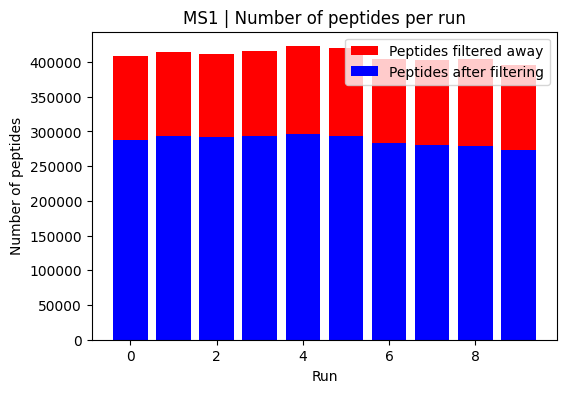

In [42]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(range(len(MS1_raw_peptides_per_run)), MS1_raw_peptides_per_run, color='red')
ax.bar(range(len(MS1_peptides_per_run)), MS1_peptides_per_run, color='blue')
ax.legend(['Peptides filtered away', 'Peptides after filtering'])

ax.set_title("MS1 | Number of peptides per run")
ax.set_xlabel("Run")
ax.set_ylabel("Number of peptides")

In [47]:
print(f"After filtering | MS1 data points: {MS1_data.shape[0]} ({MS1_data.shape[0] / MS1_raw_data.shape[0] * 100:.2f}%)")

After filtering | MS1 data points: 2871496 (70.01%)


### MS2 (MSMS) data preprocessing

Let's look at the features available in the MS2 data:

In [9]:
MS2_raw_data.columns.unique()

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Gene names',
       'Protein names', 'Type', 'Raw file', 'Experiment', 'MS/MS m/z',
       'Charge', 'm/z', 'Mass', 'Resolution',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'CCS length', 'Match time difference', 'Match m/z difference',
       '

Let's filter out low quality peptides.

In [10]:
# filter out low quality peptides
MS2_data = MS2_raw_data.loc[(MS2_raw_data['Charge'] != 1) & (MS2_raw_data['Intensity'] > 0)]

# keep the most intense peptides
MS2_data = MS2_data.loc[MS2_data.groupby(['Modified sequence', 'Charge', 'Raw file'])['Intensity'].idxmax()]

# remove contaminants
MS2_data = MS2_data.loc[[(not bool(re.search('CON__|REV__', i))) for i in MS2_data['Leading razor protein'].tolist()]]

# define identifier for each peptide
MS2_data['PrecursorID'] = MS2_data['Modified sequence'].astype(str).str.cat(MS2_data['Charge'].astype(str), sep='')

In [11]:
MS2_raw_peptides_per_run = [np.sum(MS2_raw_data['Raw file'] == run) for run in MS2_raw_data['Raw file'].unique()]
MS2_peptides_per_run = [np.sum(MS2_data['Raw file'] == run) for run in MS2_data['Raw file'].unique()]

Text(0, 0.5, 'Number of peptides')

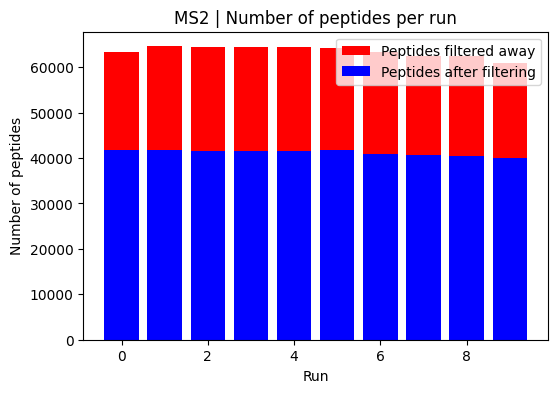

In [43]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(range(len(MS2_raw_peptides_per_run)), MS2_raw_peptides_per_run, color='red')
ax.bar(range(len(MS2_peptides_per_run)), MS2_peptides_per_run, color='blue')
ax.legend(['Peptides filtered away', 'Peptides after filtering'])

ax.set_title("MS2 | Number of peptides per run")
ax.set_xlabel("Run")
ax.set_ylabel("Number of peptides")

In [49]:
print(f"After filtering | MS2 data points: {MS2_data.shape[0]} ({MS2_data.shape[0] / MS2_raw_data.shape[0] * 100:.2f}%)")

After filtering | MS2 data points: 411838 (64.91%)


### Feature Extraction

Let's extract the features which the model takes as input.

It seems like the two datasets use a different name for 'Ion mobilility index length' / 'Ion mobility length'. Let's rename one of them to be consistent between the datasets.

In [13]:
MS1_data = MS1_data.copy()
MS1_data.rename(columns={'Ion mobility index length': 'Ion mobility length'}, inplace=True)

In [14]:
features = ['Charge','Mass', 'm/z', 'Retention time','Retention length', 'Ion mobility index', 'Ion mobility length','Number of isotopic peaks']

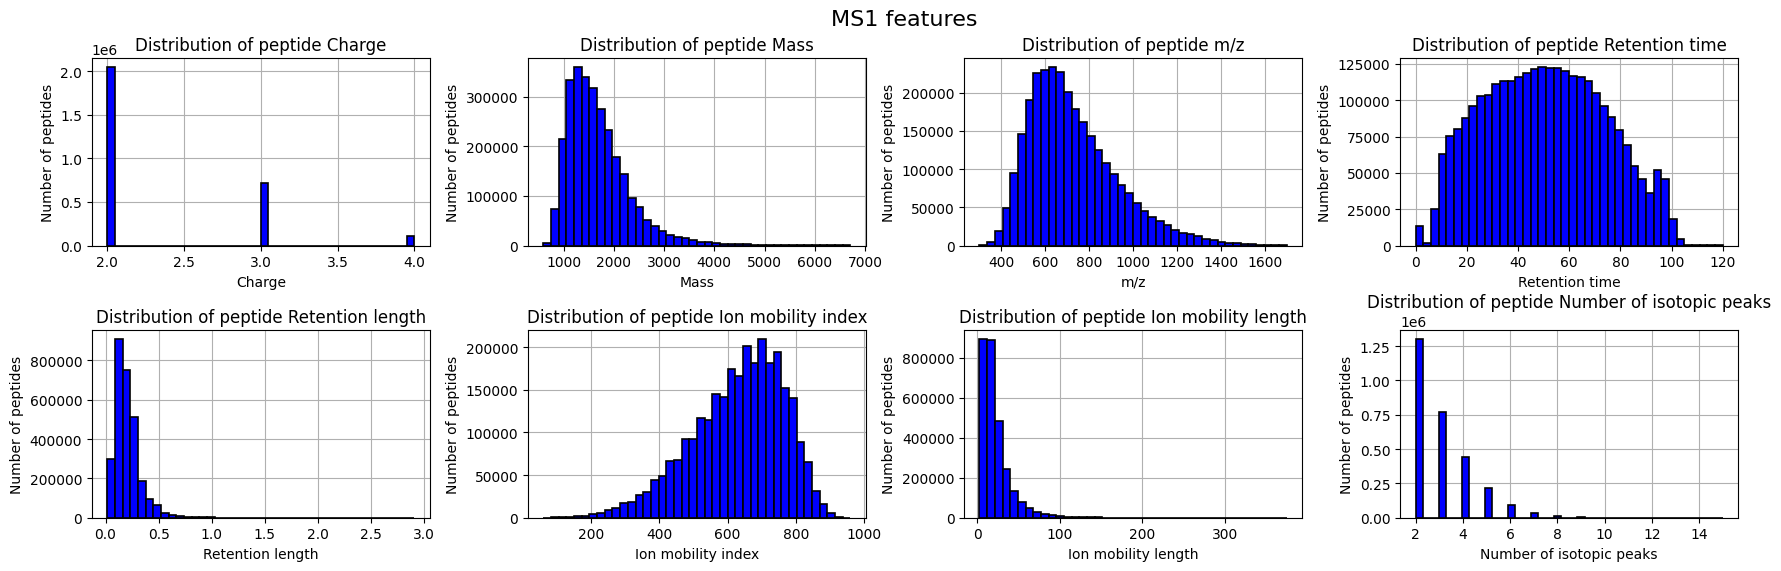

In [15]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=4, nrows=2)
fig.tight_layout(pad=4.0)
fig.suptitle('MS1 features', fontsize=16)

for i, feature in enumerate(features):
    ax = axs[i // 4][i % 4]
    ax.hist(MS1_data[feature], bins=40, color='blue', edgecolor='black', linewidth=1.2)
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of peptides')
    ax.set_title('Distribution of peptide {}'.format(feature))
    ax.grid(True)
    ax.set_axisbelow(True)

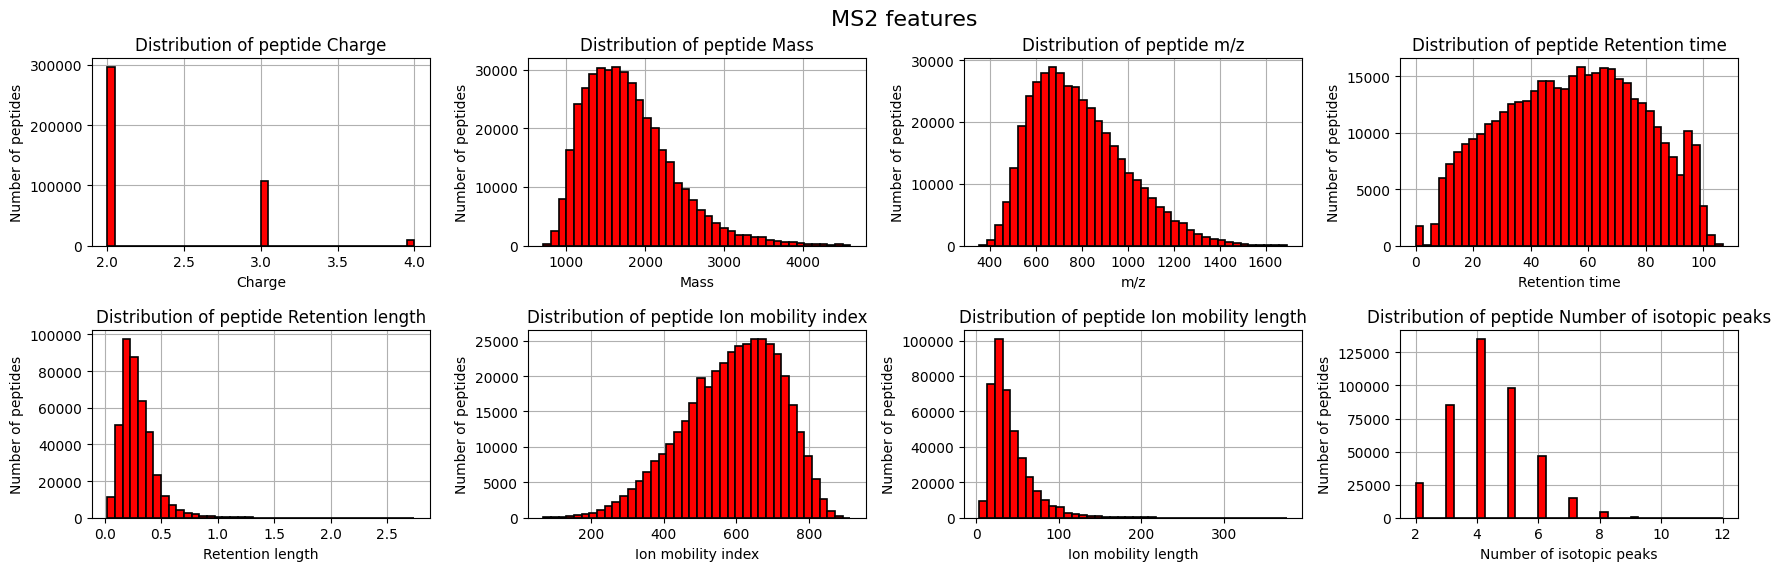

In [16]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=4, nrows=2)
fig.tight_layout(pad=4.0)
fig.suptitle('MS2 features', fontsize=16)

for i, feature in enumerate(features):
    ax = axs[i // 4][i % 4]
    ax.hist(MS2_data[feature], bins=40, color='red', edgecolor='black', linewidth=1.2)
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of peptides')
    ax.set_title('Distribution of peptide {}'.format(feature))
    ax.grid(True)
    ax.set_axisbelow(True)

In [17]:
MS1_features = MS1_data[features]
MS2_features = MS2_data[features]

## PIPP model

### Computing the Embeddings

Let's load the model and compute the embeddings.

In [18]:
model = pipp.Peptideprotonet.load(PRETRAINED_MODEL_PATH)

In [19]:
MS1_embeddings = model.get_latent_representations(MS1_features)

In [20]:
MS2_embeddings = model.get_latent_representations(MS2_features)

Let's look at the embedding space.

In [21]:
N = 50_000
indices = np.random.choice(range(len(MS2_embeddings)), size=N, replace=False)

In [136]:
MS2_data_subset = MS2_data.iloc[indices]
MS2_embeddings_subset = MS2_embeddings[indices]

In [23]:
reducer = umap.UMAP(metric = 'cosine')
umap_embedding = reducer.fit_transform(MS2_embeddings_subset)

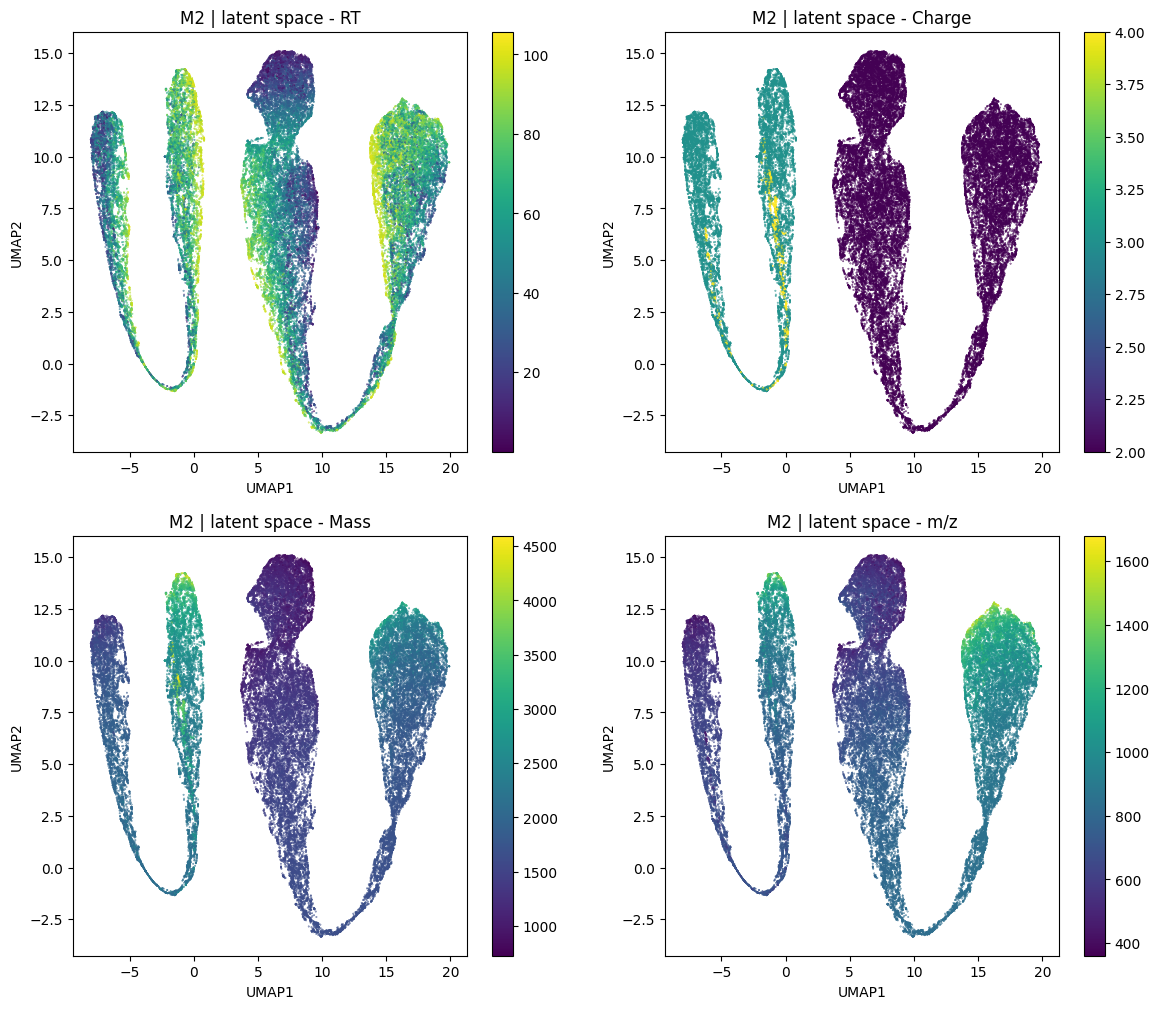

In [137]:
fig, axs = plt.subplots(figsize=(14, 12), ncols=2, nrows=2)

ax = axs[0][0]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['Retention time'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('M2 | latent space - RT')
fig.colorbar(sp)

ax = axs[0][1]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['Charge'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('M2 | latent space - Charge')
fig.colorbar(sp)

ax = axs[1][0]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['Mass'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('M2 | latent space - Mass')
fig.colorbar(sp)

ax = axs[1][1]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['m/z'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('M2 | latent space - m/z')
fig.colorbar(sp)

Let's also plot the latent space of the MS2 data together with a couple peptide for all the runs. Since we have only computed the UMAP for a random **subset** of the peptides, we will select the peptides with the most "number of runs" in this subset - for the plotting.

Text(0.5, 1.0, 'M2 | latent space - random peptides')

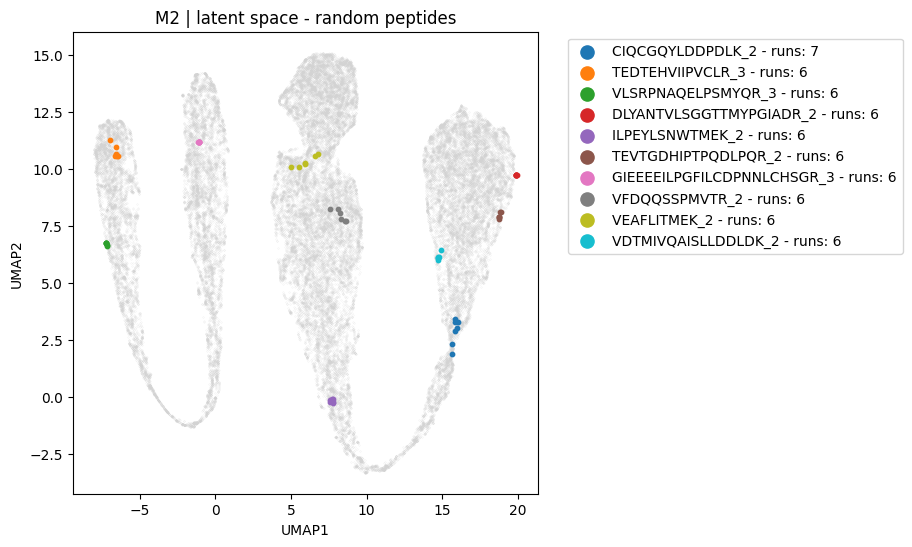

In [138]:
TOP_N = 10

ordered_precursor_ids = MS2_data_subset['PrecursorID'].value_counts()

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(umap_embedding[:,0], umap_embedding[:,1], s=0.01, color='lightgrey')

for i in range(TOP_N):
    peptide_ref = ordered_precursor_ids.index[i]
    peptide_ref_indices = np.where(MS2_data_subset['PrecursorID'] == peptide_ref)
    ax.scatter(umap_embedding[peptide_ref_indices,0], umap_embedding[peptide_ref_indices,1], s=10, color=plt.cm.tab10(i), label=f"{peptide_ref[1:]} - runs: {ordered_precursor_ids[i]}")

ax.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('M2 | latent space - random peptides')

## Peptide Identity Propagation

### Identification on the MS1 data

#### Computing the Prototypes

Let's compute the prototype for each peptide over all runs.

In [25]:
prototypes_groups = defaultdict(list)

for i in range(MS2_data.shape[0]):
    peptide = MS2_data.iloc[i]
    peptide_id = peptide['PrecursorID']
    embedding = MS2_embeddings[i]
    prototypes_groups[peptide_id].append(embedding)

In [26]:
prototypes = {k: np.mean(v, axis=0) for k, v in prototypes_groups.items()}

In [27]:
print("Number of prototypes: {}".format(len(prototypes)))

Number of prototypes: 61517


For easier access.

In [28]:
prototype_list = [(k, v) for k, v in prototypes.items()]

prototype_precursor_ids = [k for k, _ in prototype_list]
prototype_embeddings = np.array([v for _, v in prototype_list])

#### Identifying peptides

In [29]:
k = 5

index = NNDescent(prototype_embeddings, metric='euclidean', n_jobs=-1)
neighbours, distances = index.query(MS1_embeddings, k=k)

In [30]:
MS1_data['Identification'] = [prototype_precursor_ids[i] for i in neighbours[:,0]]

In [31]:
def compute_probs(distances):
    dsts = torch.from_numpy(-distances)
    probs = F.softmax(dsts, dim=1)
    return probs[:,0].numpy()

In [32]:
MS1_data['Identification Confidence'] = compute_probs(distances)

Let's plot the distribution of the confidence scores for the MS1 identifications. Additionally, we'll add a threshold to the plot, which we'll use to filter out low confidence identifications.

Text(0.41000000000000003, 500000.0, 'Peptides identified: 26966 (0.94%)')

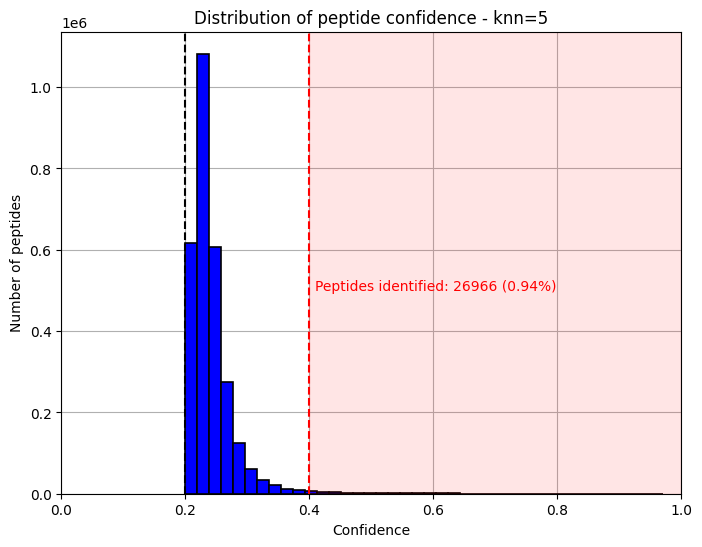

In [33]:
peptide_threshold = 0.4


fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(MS1_data['Identification Confidence'], bins=40, color='blue', edgecolor='black', linewidth=1.2)
ax.set_xlabel('Confidence')
ax.set_ylabel('Number of peptides')
ax.set_title(f'Distribution of peptide confidence - knn={k}')
ax.set_xlim([0, 1])
ax.grid(True)
ax.set_axisbelow(True)

ax.axvline(x=peptide_threshold, color='red', linestyle='--')
ax.axvline(x=1/k, color='black', linestyle='--')
ax.axvspan(peptide_threshold, 1, alpha=0.1, color='red')

identified_count = np.sum(MS1_data["Identification Confidence"] > peptide_threshold)
ax.text(peptide_threshold + 0.01, 5e5, f'Peptides identified: {identified_count} ({identified_count / len(MS1_data) * 100:.2f}%)', color='red')

### Identification on held-out MS2 run

Let's hold out all the peptides in the MS2 dataset for a specific run and see how many of them are identified.

In [34]:
runs = MS1_data['Raw file'].unique()

run_to_benchmark = runs[0]
print("Run to benchmark: {}".format(run_to_benchmark))

other_runs = runs[runs != run_to_benchmark]

MS2_data_subset = MS2_data[MS2_data['Raw file'] != run_to_benchmark]
MS2_embeddings_subset = MS2_embeddings[MS2_data['Raw file'] != run_to_benchmark]

MS2_data_benchmark = MS2_data[MS2_data['Raw file'] == run_to_benchmark].copy()
MS2_embeddings_benchmark = MS2_embeddings[MS2_data['Raw file'] == run_to_benchmark]

Run to benchmark: 20190122_HeLa_QC_Slot1-47_1_3219


#### Computing the Prototypes

Let's compute the prototypes.

In [35]:
prototypes_groups = defaultdict(list)

for i in range(MS2_data_subset.shape[0]):
    peptide = MS2_data_subset.iloc[i]
    peptide_id = peptide['PrecursorID']
    embedding = MS2_embeddings_subset[i]
    prototypes_groups[peptide_id].append(embedding)

In [36]:
prototypes = {k: np.mean(v, axis=0) for k, v in prototypes_groups.items()}

In [37]:
print("Number of prototypes: {}".format(len(prototypes)))

Number of prototypes: 60544


For easier access.

In [38]:
prototype_list = [(k, v) for k, v in prototypes.items()]

prototype_precursor_ids = [k for k, _ in prototype_list]
prototype_embeddings = np.array([v for _, v in prototype_list])

#### Identifying peptides

In [39]:
k = 5

index = NNDescent(prototype_embeddings, metric='euclidean', n_jobs=-1)
neighbours, distances = index.query(MS2_embeddings_benchmark, k=k)

In [40]:
MS2_data_benchmark['Identification'] = [prototype_precursor_ids[i] for i in neighbours[:,0]]
MS2_data_benchmark['Identification Confidence'] = compute_probs(distances)

Let's plot the distribution of the confidence scores for the MS2 identifications. Additionally, we'll add a threshold to the plot, which we'll use to filter out low confidence identifications.

Text(0.21000000000000002, 5000, 'Peptides identified correctly: 28599 (68.49%)')

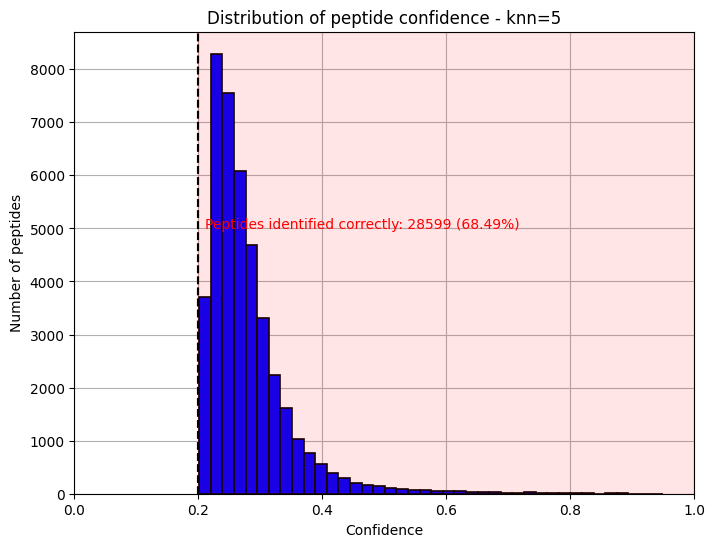

In [51]:
peptide_threshold = 0.2


fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(MS2_data_benchmark['Identification Confidence'], bins=40, color='blue', edgecolor='black', linewidth=1.2)
ax.set_xlabel('Confidence')
ax.set_ylabel('Number of peptides')
ax.set_title(f'Distribution of peptide confidence - knn={k}')
ax.set_xlim([0, 1])
ax.grid(True)
ax.set_axisbelow(True)

ax.axvline(x=peptide_threshold, color='red', linestyle='--')
ax.axvline(x=1/k, color='black', linestyle='--')
ax.axvspan(peptide_threshold, 1, alpha=0.1, color='red')

benchmark_threshold = MS2_data_benchmark[MS2_data_benchmark['Identification Confidence'] > peptide_threshold]
matches = np.sum(benchmark_threshold['PrecursorID'] == benchmark_threshold['Identification'])

identified_count = np.sum(MS2_data_benchmark['Identification Confidence'] > peptide_threshold)
ax.text(peptide_threshold + 0.01, 5000, f'Peptides identified correctly: {matches} ({matches / benchmark_threshold.shape[0] * 100:.2f}%)', color='red')